In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import keras.utils as image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add 

In [2]:
with open(r"Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [3]:
captions = captions.split("\n")[:-1]

In [4]:
len(captions)

40460

In [5]:
descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
    descriptions[img_name].append(cap)

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
# Data cleaning

def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ", sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    return sample

In [8]:
clean_text("My sqoao12joa si am nias &&9asokja asklmksajsoid klasjd998ak")

'my sqoao joa si am nias asokja asklmksajsoid klasjd ak'

In [9]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [10]:
descriptions["978580450_e862715aba"]

['blonde child swims',
 'boy is swimming in open water',
 'child submerges from the water',
 'kid comes up from the water',
 'the small child comes up from underwater']

In [11]:
f = open("descriptions.txt", "w")
f.write(str(descriptions))
f.close()

In [12]:
f = open("descriptions.txt", "r")
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [13]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]
print("Vocabulary size: %d" % len(vocabulary))

Vocabulary size: 8424


In [14]:
all_vocab = []
for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
print("Vocabulary Size: %d" % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [15]:
import collections

counter = collections.Counter(all_vocab)
dic_ = dict(counter)
threshold_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key=lambda x:x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshold_value]
all_vocab = [x[0] for x in sorted_dic]

In [16]:
len(all_vocab)

1845

In [17]:
f = open("Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [18]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [19]:
f = open("Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [20]:
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [21]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " ending"
        train_descriptions[t].append(cap_to_append)
        

In [22]:
train_descriptions["978580450_e862715aba"]

['startseq blonde child swims ending',
 'startseq boy is swimming in open water ending',
 'startseq child submerges from the water ending',
 'startseq kid comes up from the water ending',
 'startseq the small child comes up from underwater ending']

In [23]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [24]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [25]:
model_now = Model(model.input, model.layers[-2].output)

In [26]:
images = "imagedataset/"

In [27]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [28]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_now.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
start = time()
encoding_train = {}

for ix, img in enumerate(train):
    img = "imagedataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image= "+ str(ix))
print("Time taken in seconds =", time()-start())

In [ ]:
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [29]:
import pickle as pkl
with open("encodin_train_features.pkl", "rb") as f:
    encoding_train = pkl.load(f)

In [ ]:
start = time()
encoding_test = {}

for ix, img in enumerate(test):
    img = "imagedataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image= "+ str(ix))
print("Time taken in seconds =", time()-start())

In [ ]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [30]:
with open("encoded_test_images.pkl", "rb") as f:
    encoding_test = pkl.load(f)

In [31]:
ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix+=1

In [32]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847
idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [33]:
vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [34]:
all_captions_len = []
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))
max_len = max(all_captions_len)
print(max_len)

35


In [35]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):
    X1, X2, y = [],[],[]
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n +=1 
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                u = np.array(X1)
                v = np.array(X2)
                w = np.array(y)
                yield([u,v],w)
                X1, X2, y = [],[],[]
                n=0

In [36]:
f = open("glove_6B_50d.txt", encoding='utf8')

In [37]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float')
    
    embedding_index[word] = coefs
f.close()

In [38]:
def get_embedding_output():
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    return embedding_output
embedding_output = get_embedding_output()

In [39]:
embedding_output.shape

(1848, 50)

In [40]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation="relu")(inp_img1)

In [41]:
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [42]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [44]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [45]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [46]:
#Train
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)

In [47]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
    print("training...")
    model.save('model_weights/model_'+ str(i)+ '.h5')

Epoch 1/10
6000/6000 [==============================] - 721s 120ms/step - loss: 3.9557
Epoch 2/10
6000/6000 [==============================] - 767s 128ms/step - loss: 3.2405
Epoch 3/10
6000/6000 [==============================] - 755s 126ms/step - loss: 3.0097
Epoch 4/10
6000/6000 [==============================] - 738s 123ms/step - loss: 2.8824
Epoch 5/10
6000/6000 [==============================] - 730s 122ms/step - loss: 2.7931
Epoch 6/10
6000/6000 [==============================] - 748s 125ms/step - loss: 2.7331
Epoch 7/10
6000/6000 [==============================] - 736s 123ms/step - loss: 2.6869
Epoch 8/10
6000/6000 [==============================] - 783s 131ms/step - loss: 2.6503
Epoch 9/10
6000/6000 [==============================] - 737s 123ms/step - loss: 2.6224
Epoch 10/10
6000/6000 [==============================] - 736s 123ms/step - loss: 2.5972
training...
Epoch 1/10
6000/6000 [==============================] - 737s 123ms/step - loss: 2.5775
Epoch 2/10
6000/6000 [========

KeyboardInterrupt: 

In [49]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [50]:
model = load_model("model_9.h5")

In [51]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += ' ' + word
        
        if word == 'endseq':
            break
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [60]:
img_path = 'imagedataset/'

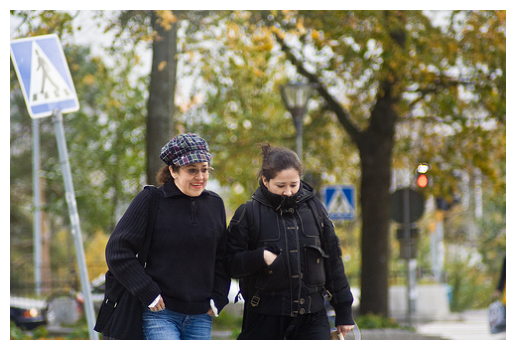

C:\Users\ADM\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 168ms/step
man in leather jacket and black hat is walking on the grass


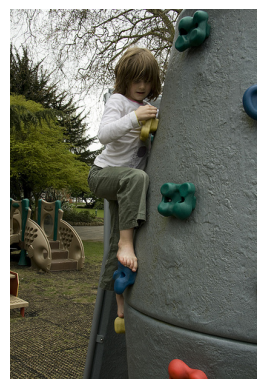

1/1 [==============================] - 0s 146ms/step
little boy in red shirt and jeans is sitting on the floor


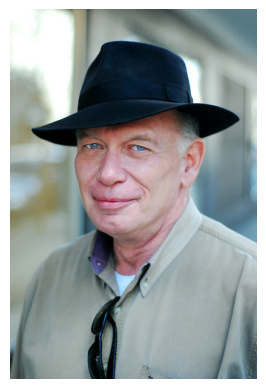

1/1 [==============================] - 0s 149ms/step
man with sunglasses and leather jacket


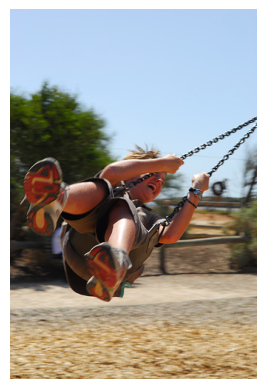

1/1 [==============================] - 0s 145ms/step
boy in blue shirt and helmet rides unicycle


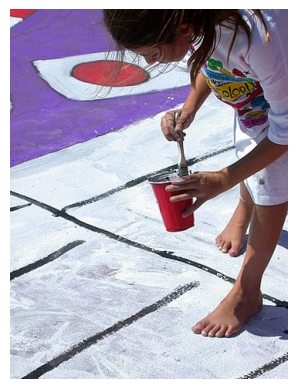

1/1 [==============================] - 0s 178ms/step
boy in shorts is jumping on rock wall


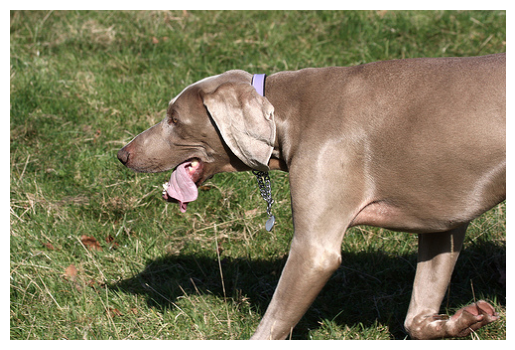

1/1 [==============================] - 0s 161ms/step
brown dog is running on the grass


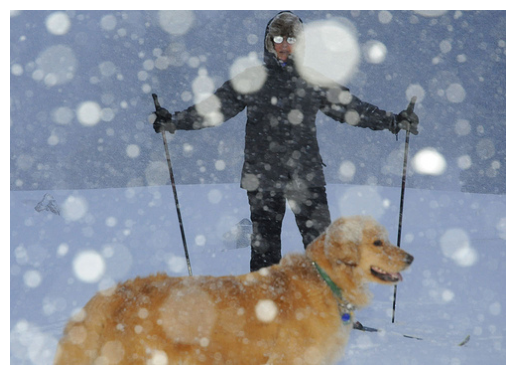

1/1 [==============================] - 0s 149ms/step
two dogs are playing in the snow


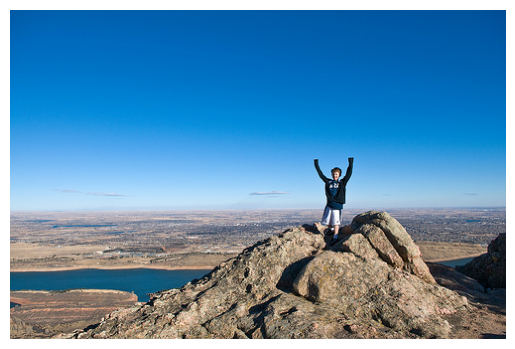

1/1 [==============================] - 0s 135ms/step
man is standing on top of cliff overlooking the mountains


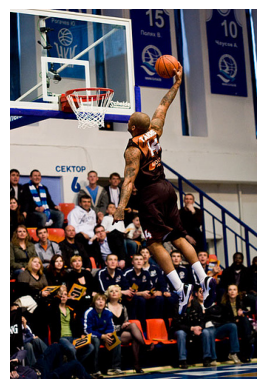

1/1 [==============================] - 0s 149ms/step
two men in the air


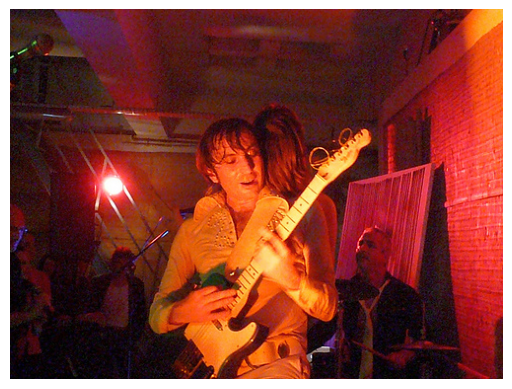

1/1 [==============================] - 0s 146ms/step
man in red shirt and white shirt is standing in crowd of people


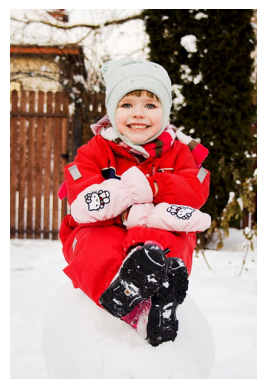

1/1 [==============================] - 0s 148ms/step
child in red coat is holding stuffed of snow


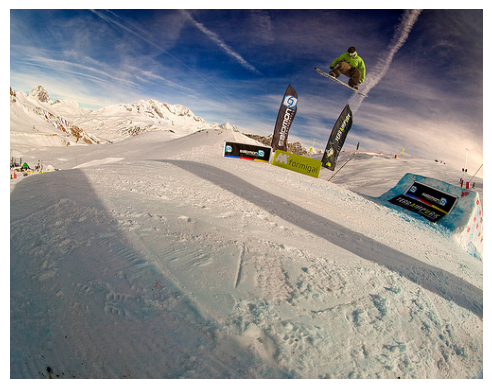

1/1 [==============================] - 0s 154ms/step
man in green shirt and green shirt is jumping over the air


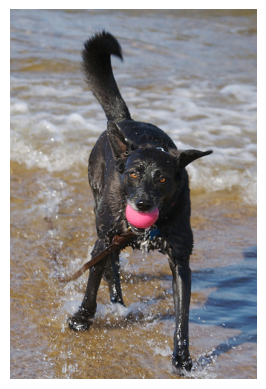

1/1 [==============================] - 0s 146ms/step
black dog is running through the water


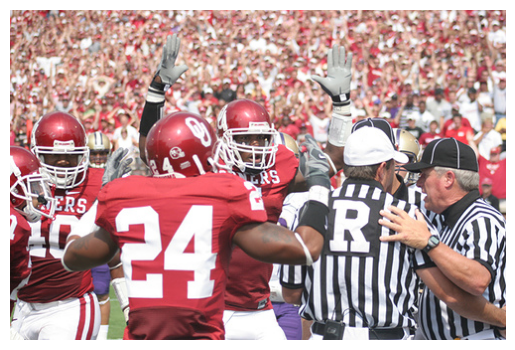

1/1 [==============================] - 0s 145ms/step
football player in purple is being by player in purple


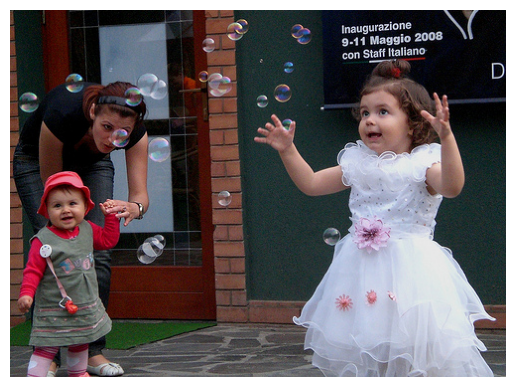

1/1 [==============================] - 0s 145ms/step
group of people are standing in front of some adults


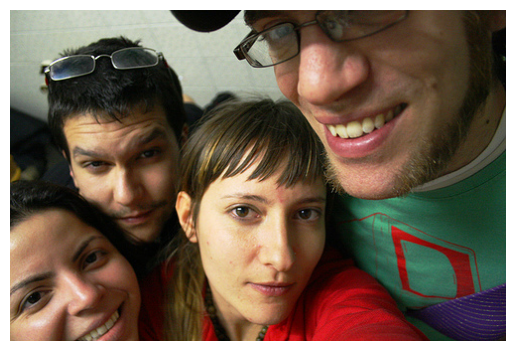

1/1 [==============================] - 0s 159ms/step
two women pose for picture


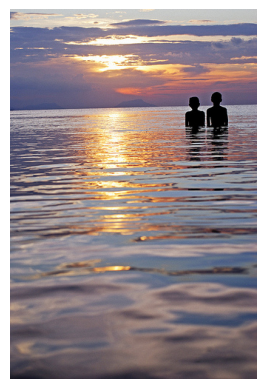

1/1 [==============================] - 0s 147ms/step
person kayaks through the water


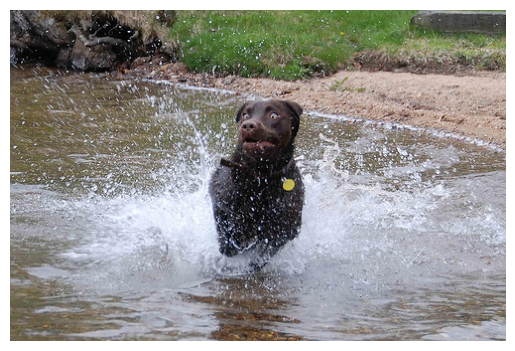

1/1 [==============================] - 0s 159ms/step
black dog is running through the water


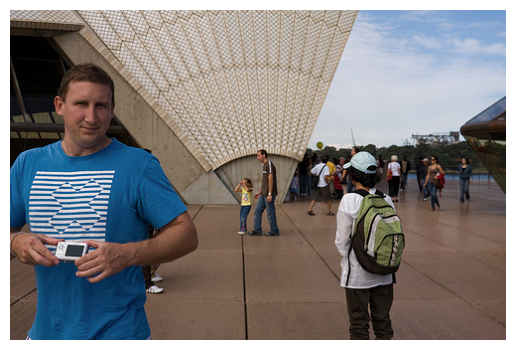

1/1 [==============================] - 0s 150ms/step
man with camera is standing on tripod and another man stands on the phone


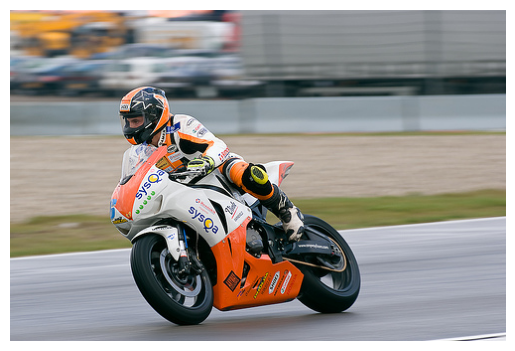

1/1 [==============================] - 0s 156ms/step
man in red jacket is riding motorcycle


In [63]:
for i in range(20):
    rn = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(img_path+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    
    caption = predict_caption(photo)
    
    print(caption)